In [1]:
from pathlib import Path
from itertools import product
import urllib.request
import tarfile
from typing import Union, Sequence

def load_nba_data(path: Union[Path, str] = Path.cwd(),
                  seasons: Union[Sequence, int] = range(1996, 2023),
                  data: Union[Sequence, str] = ("datanba", "nbastats", "pbpstats",
                                                "shotdetail", "cdnnba", "nbastatsv3"),
                  seasontype: str = 'rg',
                  untar: bool = False) -> None:
    """
    Loading a nba play-by-play dataset from github repository https://github.com/shufinskiy/nba_data

    Args:
        path (Union[Path, str]): Path where downloaded file should be saved on the hard disk
        seasons (Union[Sequence, int]): Sequence or integer of the year of start of season
        data (Union[Sequence, str]): Sequence or string of data types to load
        seasontype (str): Part of season: rg - Regular Season, po - Playoffs
        untar (bool): Logical: do need to untar loaded archive

    Returns:
        None
    """
    if isinstance(path, str):
        path = Path(path)
    if isinstance(seasons, int):
        seasons = (seasons,)
    if isinstance(data, str):
        data = (data,)

    if seasontype == 'rg':
        need_data = tuple(["_".join([data, str(season)]) for (data, season) in product(data, seasons)])
    elif seasontype == 'po':
        need_data = tuple(["_".join([data, seasontype, str(season)]) \
                           for (data, seasontype, season) in product(data, (seasontype,), seasons)])
    else:
        need_data_rg = tuple(["_".join([data, str(season)]) for (data, season) in product(data, seasons)])
        need_data_po = tuple(["_".join([data, seasontype, str(season)]) \
                              for (data, seasontype, season) in product(data, ('po',), seasons)])
        need_data = need_data_rg + need_data_po

    with urllib.request.urlopen("https://raw.githubusercontent.com/shufinskiy/nba_data/main/list_data.txt") as f:
        v = f.read().decode('utf-8').strip()

    name_v = [string.split("=")[0] for string in v.split("\n")]
    element_v = [string.split("=")[1] for string in v.split("\n")]

    need_name = [name for name in name_v if name in need_data]
    need_element = [element for (name, element) in zip(name_v, element_v) if name in need_data]

    for i in range(len(need_name)):
        t = urllib.request.urlopen(need_element[i])
        with path.joinpath("".join([need_name[i], ".tar.xz"])).open(mode='wb') as f:
            f.write(t.read())
        if untar:
            with tarfile.open(path.joinpath("".join([need_name[i], ".tar.xz"]))) as f:
                f.extract("".join([need_name[i], ".csv"]), path)

            path.joinpath("".join([need_name[i], ".tar.xz"])).unlink()

In [2]:
load_nba_data(path='/content', seasons=range(2024, 2025), data="pbpstats", seasontype='rg', untar=True)


In [3]:
import pandas as pd

# Load the pbpstats data (assuming you've already loaded it as pbpstats_data)
# If this dataset is loaded from a file, adjust the path to the correct one
pbpstats_file = '/content/pbpstats_2024.csv'  # Adjust path based on where the file is saved
pbpstats_data = pd.read_csv(pbpstats_file)

# Extract and create the new columns:
pbpstats_data['TIME_REMAINING'] = pbpstats_data['ENDTIME']  # Use ENDTIME for time remaining

# Use STARTSCOREDIFFERENTIAL for points differential
pbpstats_data['POINTS_DIFFERENTIAL'] = pbpstats_data['STARTSCOREDIFFERENTIAL']

# Create the 'HOME_AWAY' column based on the opponent's team
# Assuming 'OPPONENT' indicates the away team, so if the opponent is 'IND', it's the home team
pbpstats_data['HOME_AWAY'] = pbpstats_data['OPPONENT'].apply(lambda x: 'Home' if x == 'IND' else 'Away')

# Assuming PLAYER1_TEAM_NICKNAME exists, or use another column that identifies the team
# Adjust the column if necessary based on your dataset
pbpstats_data['TEAM'] = pbpstats_data['OPPONENT']  # Assuming 'OPPONENT' represents the team for this example

# Now pbpstats_data contains only the columns you're interested in
# Display the selected columns
df = pbpstats_data[['TIME_REMAINING', 'POINTS_DIFFERENTIAL', 'HOME_AWAY', 'TEAM']]


In [4]:
df

,TIME_REMAINING,POINTS_DIFFERENTIAL,HOME_AWAY,TEAM
0,00:03,1,Away,BOS
1,00:06,-1,Away,BOS
2,00:06,-1,Away,BOS
3,00:06,-1,Away,BOS
4,00:42,-3,Away,BOS
...,...,...,...,...
125395,10:13,-2,Away,MIN
125396,10:48,-2,Away,MIN
125397,10:48,-2,Away,MIN
125398,11:15,0,Away,MIN


In [5]:
import pandas as pd

# Perform one-hot encoding only for the 'TEAM' column (without dropping any columns)
df_encoded = pd.get_dummies(df, columns=['TEAM'], drop_first=False)

# Convert only the team columns (that were generated) to 0 and 1
team_columns = [col for col in df_encoded.columns if 'TEAM_' in col]
df_encoded[team_columns] = df_encoded[team_columns].astype(int)

# Display the first few rows of the resulting DataFrame
df_encoded


,TIME_REMAINING,POINTS_DIFFERENTIAL,HOME_AWAY,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,...,TEAM_OKC,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS
0,00:03,1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00:06,-1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00:06,-1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00:06,-1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00:42,-3,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125395,10:13,-2,Away,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125396,10:48,-2,Away,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125397,10:48,-2,Away,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125398,11:15,0,Away,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_encoded['WIN'] = (df_encoded['POINTS_DIFFERENTIAL'] > 0).astype(int)

In [7]:
df_encoded.head(10)

,TIME_REMAINING,POINTS_DIFFERENTIAL,HOME_AWAY,TEAM_ATL,TEAM_BKN,TEAM_BOS,TEAM_CHA,TEAM_CHI,TEAM_CLE,TEAM_DAL,...,TEAM_ORL,TEAM_PHI,TEAM_PHX,TEAM_POR,TEAM_SAC,TEAM_SAS,TEAM_TOR,TEAM_UTA,TEAM_WAS,WIN
0,00:03,1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00:06,-1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00:06,-1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00:06,-1,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00:42,-3,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,01:09,-4,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,01:09,-4,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,01:09,-4,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,01:39,-3,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,02:15,0,Away,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Convert the 'TIME_REMAINING' column to seconds
def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(":"))
    return minutes * 60 + seconds

df_encoded['TIME_REMAINING'] = df_encoded['TIME_REMAINING'].apply(time_to_seconds)

# Now 'TIME_REMAINING' is in seconds and can be used for the regression model


In [9]:
# Perform one-hot encoding on the 'HOME_AWAY' column
df_encoded = pd.get_dummies(df_encoded, columns=['HOME_AWAY'], drop_first=True)

In [10]:
X = df_encoded.drop(columns=['WIN'])
y = df_encoded['WIN']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20900
           1       1.00      1.00      1.00     16720

    accuracy                           1.00     37620
   macro avg       1.00      1.00      1.00     37620
weighted avg       1.00      1.00      1.00     37620

Confusion Matrix:
[[20900     0]
 [    0 16720]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, classification_report
)
from sklearn.model_selection import cross_val_score

def evaluate_classification_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates a classification model with confusion matrix and ROC curve.

    Parameters:
        model: Trained classification model.
        X_train, y_train: Training data and labels.
        X_test, y_test: Test data and labels.

    Returns:
        None. Displays evaluation metrics, confusion matrix, and ROC curve.
    """
    # Train and test accuracy
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"Training Accuracy: {train_score:.4f}")
    print(f"Test Accuracy: {test_score:.4f}")

    # Overfitting or underfitting check
    if train_score > test_score + 0.1:
        print("Warning: The model may be overfitting.")
    elif train_score < 0.6 and test_score < 0.6:
        print("Warning: The model may be underfitting.")

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

    # Confusion Matrix
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):  # Use predict_proba if available
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):  # Use decision_function otherwise
        y_test_proba = model.decision_function(X_test)
    else:
        raise AttributeError("Model does not support predict_proba or decision_function for ROC.")

    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Suggestions based on performance
    if train_score > test_score + 0.1:
        print("The model might benefit from regularization or reducing complexity.")
    elif train_score < 0.6 and test_score < 0.6:
        print("The model might benefit from additional features or increased complexity.")
    else:
        print("The model appears well-balanced.")


Training Accuracy: 1.0000
Test Accuracy: 1.0000
Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20900
           1       1.00      1.00      1.00     16720

    accuracy                           1.00     37620
   macro avg       1.00      1.00      1.00     37620
weighted avg       1.00      1.00      1.00     37620



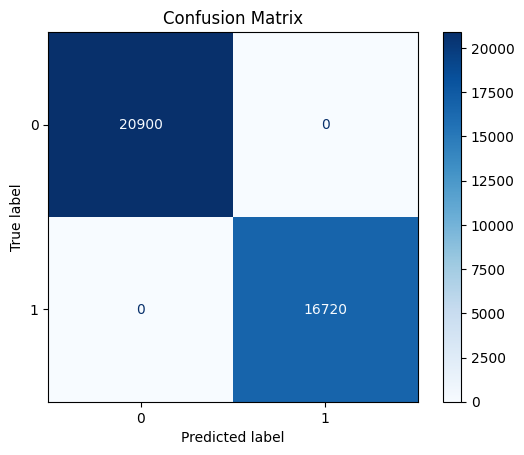

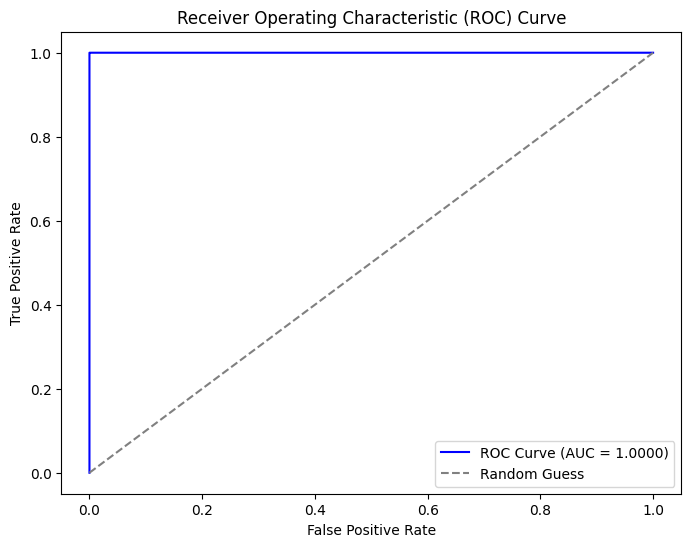

The model appears well-balanced.


In [ ]:
evaluate_classification_model(model, X_train, y_train, X_test, y_test)

In [50]:
import bs4
from bs4 import BeautifulSoup
import requests
import pandas as pd


def extract_money_lines(url, dateStr):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36'}
    payload = {
        'sport': 'basketball',
        'league': 'nba',
        'region': 'us',
        'lang': 'en',
        'contentorigin': 'espn',
        'buyWindow': '1m',
        'showAirings': 'buy,live,replay',
        'tz': 'America/New_York',
        'dates': dateStr}

    response = requests.get(url, headers=headers, params=payload).json()
    events = response['sports'][0]['leagues'][0]['events']

    df = pd.json_normalize(events,
                           record_path=['competitors'],
                           meta=['odds', ['odds', 'away', 'moneyLine'], ['odds', 'home', 'moneyLine']],
                           errors='ignore')

    reshaped_data = []

    for i in range(0, len(df), 2):
        row_away = df.iloc[i]
        row_home = df.iloc[i + 1]
        reshaped_row = {
            'away': f"{row_away['displayName']}",
            'home': f"{row_home['displayName']}",
            'odds.away.moneyLine': row_away['odds.away.moneyLine'],
            'odds.home.moneyLine': row_home['odds.home.moneyLine']
        }
        reshaped_data.append(reshaped_row)

    reshaped_df = pd.DataFrame(reshaped_data)

    return reshaped_df

In [49]:
import pytz
from datetime import datetime

def moneyline_data():
    usa_timezone = pytz.timezone('America/New_York')
    current_time_usa = datetime.now(usa_timezone)
    dateStr = current_time_usa.strftime('%Y%m%d')
    url = "https://site.web.api.espn.com/apis/v2/scoreboard/header"
    df = extract_money_lines(url, dateStr)
    return df

In [48]:
df = moneyline_data()
df

,away,home,odds.away.moneyLine,odds.home.moneyLine
0,New York Knicks,Toronto Raptors,-250,210
